# ARIMA MODEL TRAINING
---

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helpers import (
    find_best_sarima_cached,
    find_missing_date_ranges,
    present_base_dataset,
    evaluate_predictions,
    compare_prediction,
)
from enums import (
    DatasetColumns,
    WeatherDatasetColumns
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Data Preparation
---


In [2]:
#  Constants
FILE_NAME = "dataset.csv"
WEATHER_DATASET = "dataset_weather.csv"

In [3]:
# Load data
original_data = pd.read_csv(
    FILE_NAME,
    parse_dates=[DatasetColumns.STATISTICAL_PERIOD.value],
    index_col=DatasetColumns.STATISTICAL_PERIOD.value,
)

weather_data = pd.read_csv(
    WEATHER_DATASET,
    parse_dates=[WeatherDatasetColumns.DATETIME.value],
    index_col=WeatherDatasetColumns.DATETIME.value,
).asfreq("h")

weather_features = [
    WeatherDatasetColumns.TEMPERATURE_C.value,
    WeatherDatasetColumns.HUMIDITY_PERCENT.value,
]

In [4]:
# Find missing date ranges
gap_start, gap_end = find_missing_date_ranges(
    original_data, DatasetColumns.STATISTICAL_PERIOD.value
)

In [5]:
# Split data
pre_gap_data = original_data[original_data.index < gap_start].asfreq("h")
pre_gap_train_size = int(len(pre_gap_data) * 0.8)
pre_gap_train = pre_gap_data.iloc[:pre_gap_train_size]
pre_gap_test = pre_gap_data.iloc[pre_gap_train_size:]

post_gap_data = original_data[original_data.index >= gap_end].asfreq('h')

pre_weather_data = weather_data[weather_data.index < gap_start].bfill()
post_weather_data = weather_data[weather_data.index >= gap_end].bfill()

Missing range: 2023-12-05 to 2024-01-30


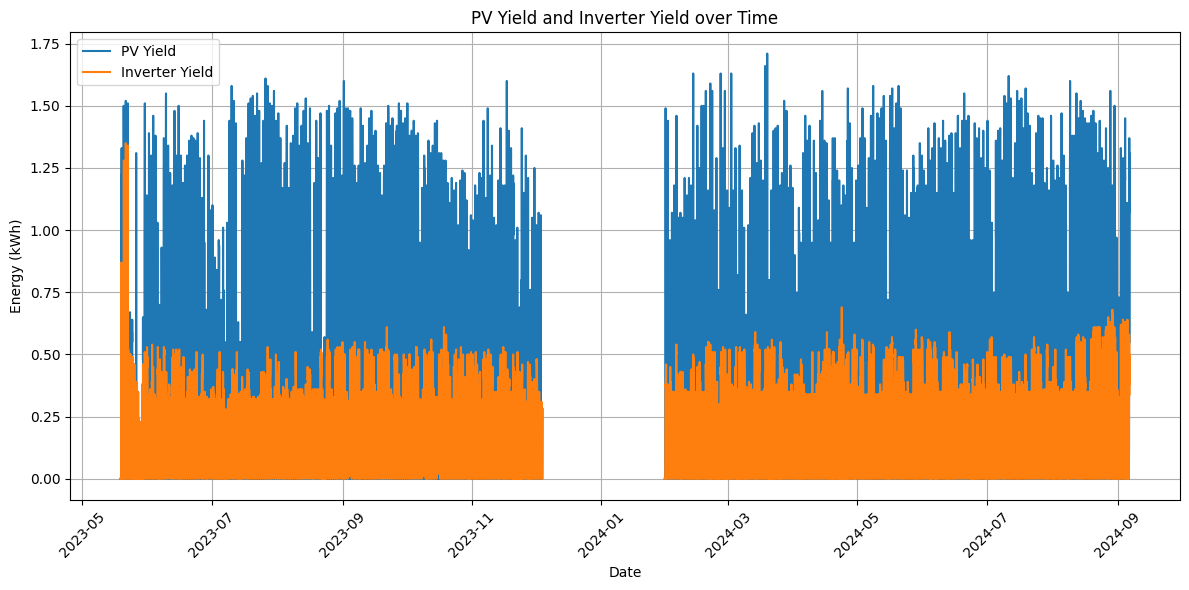

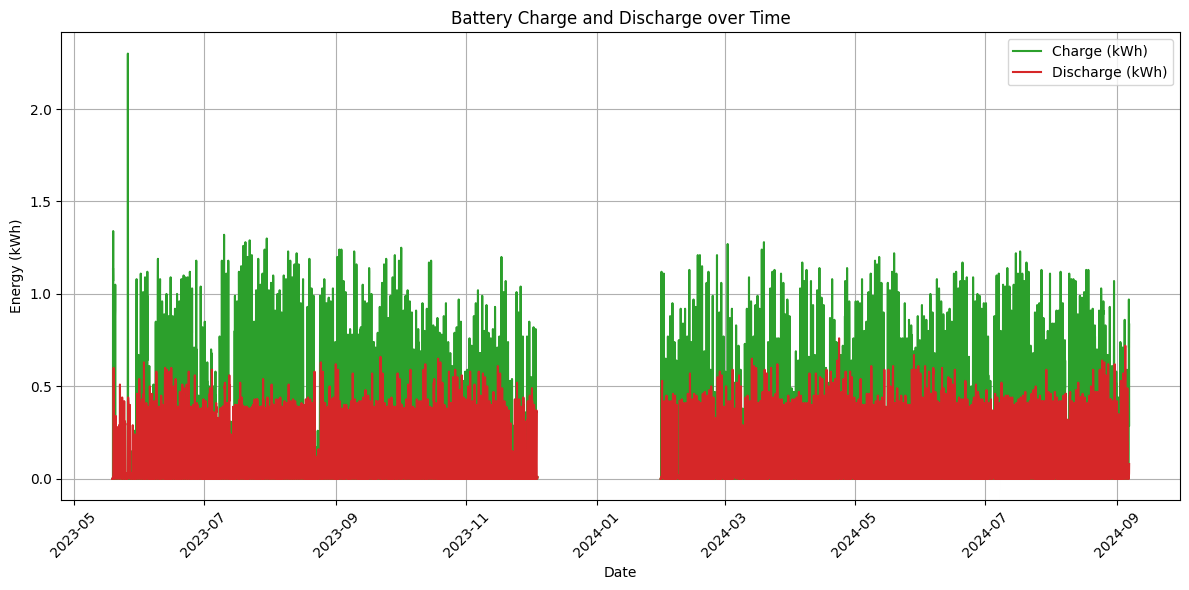

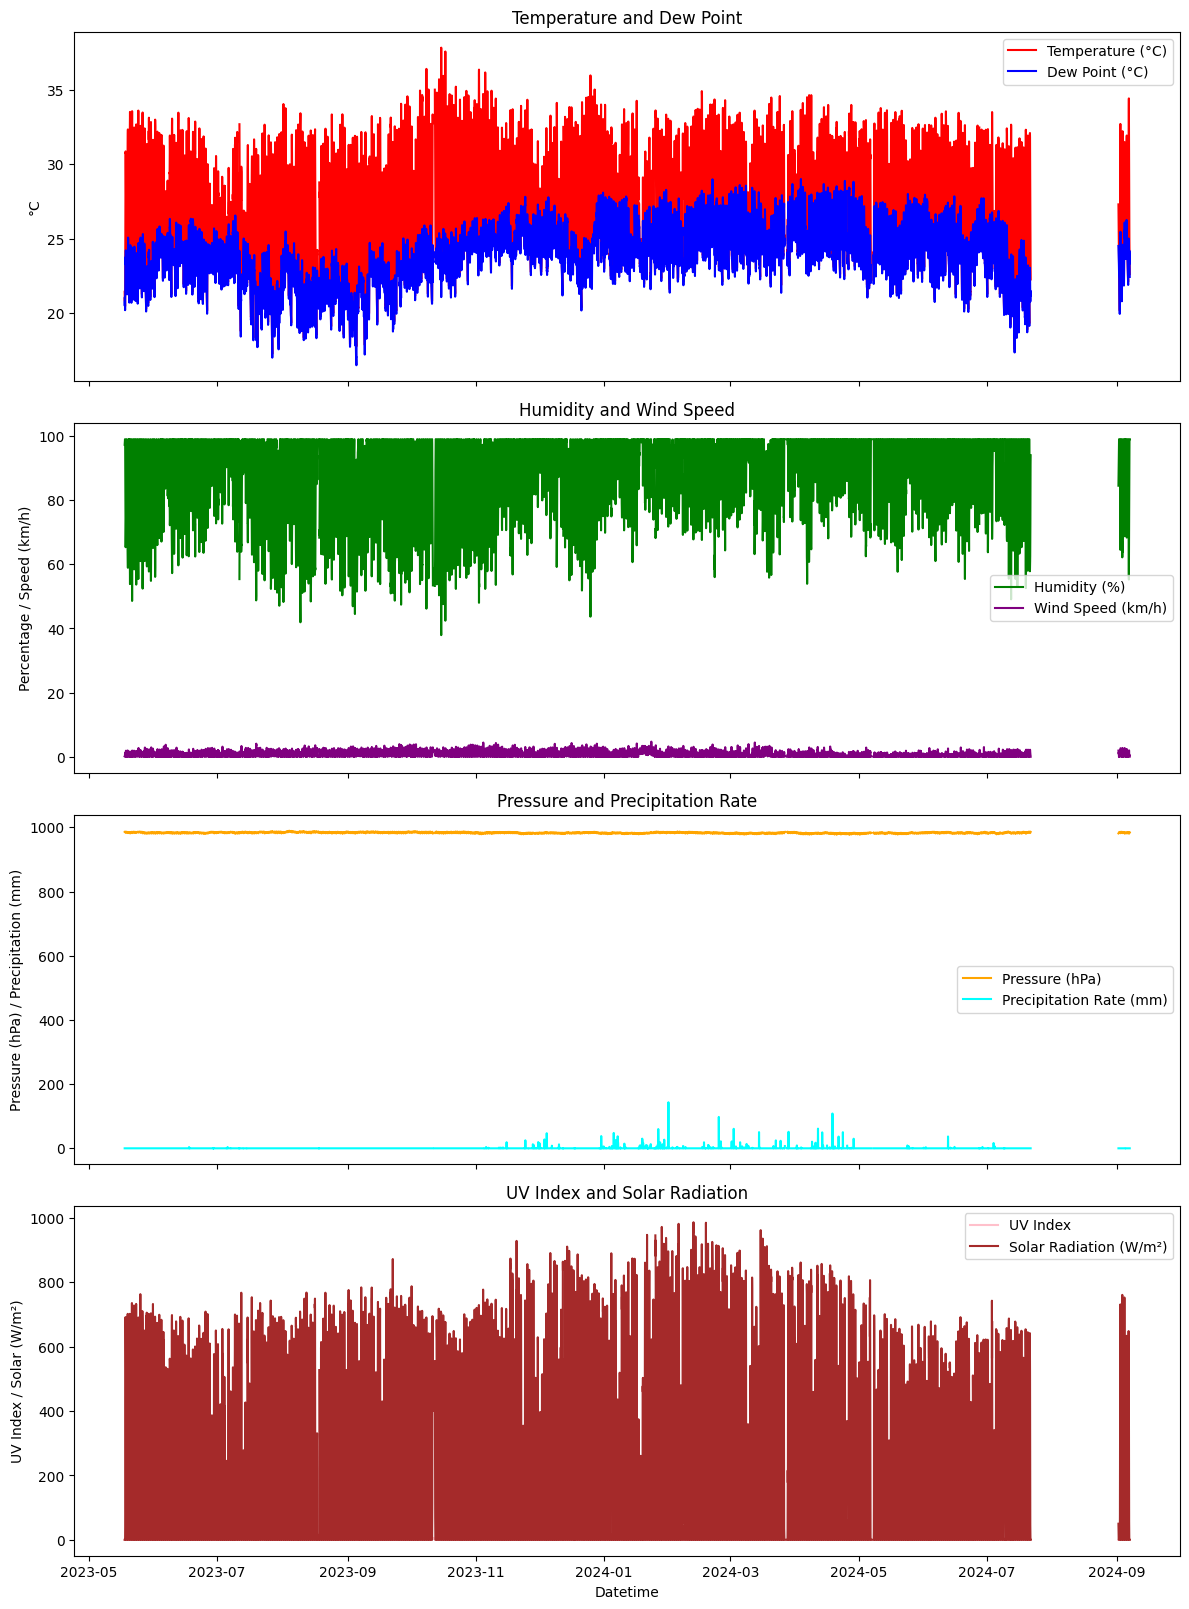

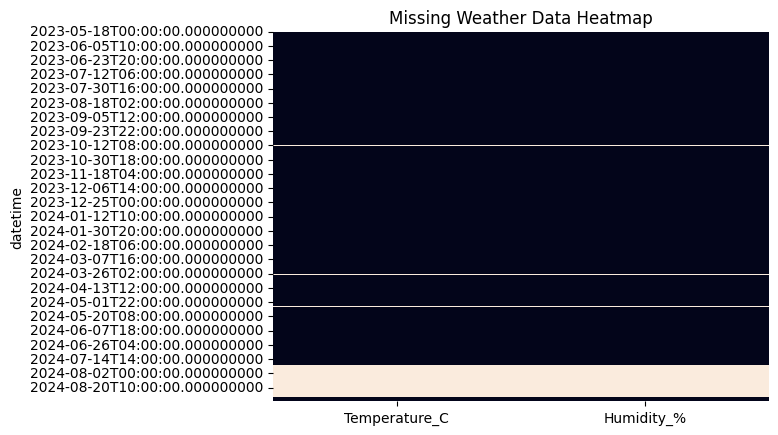

In [6]:
print(f"Missing range: {gap_start.date()} to {gap_end.date()}")
present_base_dataset(original_data, weather_data, weather_features)

## `pre_gap_data` training model
---

In [7]:
# Tune hyperparameters
p = d = q = range(0, 3)
P = D = Q = range(0, 2)  # Seasonal components
seasonal_period = 24  # Set seasonal period, e.g., daily seasonality for hourly data


best_params, best_aic = find_best_sarima_cached(
    pre_gap_train[DatasetColumns.PV_YIELD.value],
    seasonal_period,
    p,
    d,
    q,
    P,
    D,
    Q,
)

(order_params, seasonal_params) = best_params
print(f"Best Parameters: {best_params}, AIC: {best_aic}")

Best Parameters: ((2, 0, 1), (1, 1, 1)), AIC: -4800.7984059159135


10% of Mean Value (Target MAE/RMSE): 0.021322580645161293
Mean Absolute Error (MAE): 0.29277303336453553
Mean Squared Error (MSE): 0.12666080579037906
Root Mean Squared Error (RMSE): 0.35589437448543504


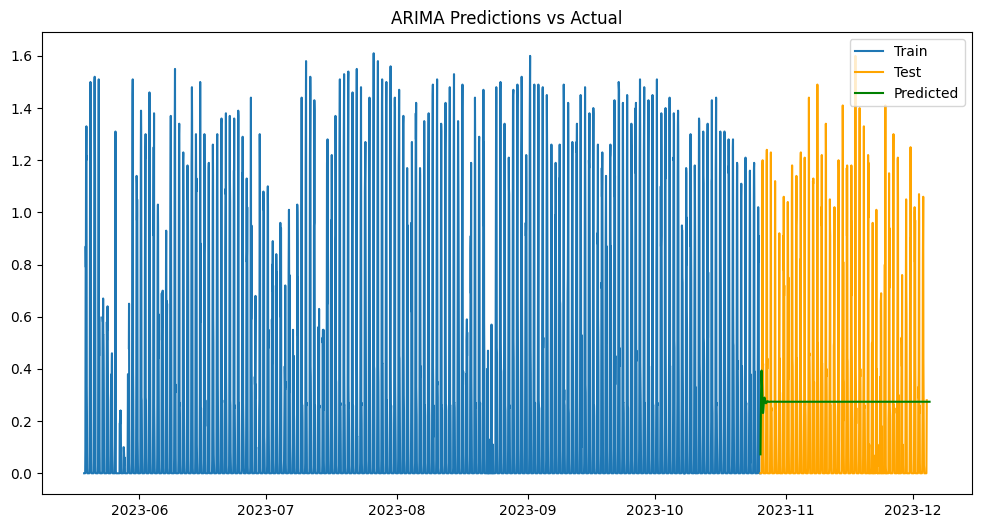

In [15]:
# Train without exocgenous variables and seasonal components
def train_arima_model():
    arima_model = ARIMA(
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        order=order_params,  
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    arima_result = arima_model.fit()
    preds = arima_result.predict(start=pre_gap_test.index[0], end=pre_gap_test.index[-1])

    # Evaluate Predictions
    evaluate_predictions(pre_gap_test[DatasetColumns.PV_YIELD.value], preds)    
    
    # Compare Actual vs Predicted
    compare_prediction(
        "ARIMA Predictions vs Actual",
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        pre_gap_test[DatasetColumns.PV_YIELD.value],
        preds,
    )
    
train_arima_model()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.31893D-01    |proj g|=  1.35874D+00

At iterate    5    f= -5.57504D-01    |proj g|=  7.04175D-01

At iterate   10    f= -6.06000D-01    |proj g|=  9.98309D-01

At iterate   15    f= -6.26520D-01    |proj g|=  3.13923D-02

At iterate   20    f= -6.26620D-01    |proj g|=  3.43994D-04

At iterate   25    f= -6.26620D-01    |proj g|=  5.65299D-03

At iterate   30    f= -6.26636D-01    |proj g|=  1.59748D-02

At iterate   35    f= -6.26666D-01    |proj g|=  7.07392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

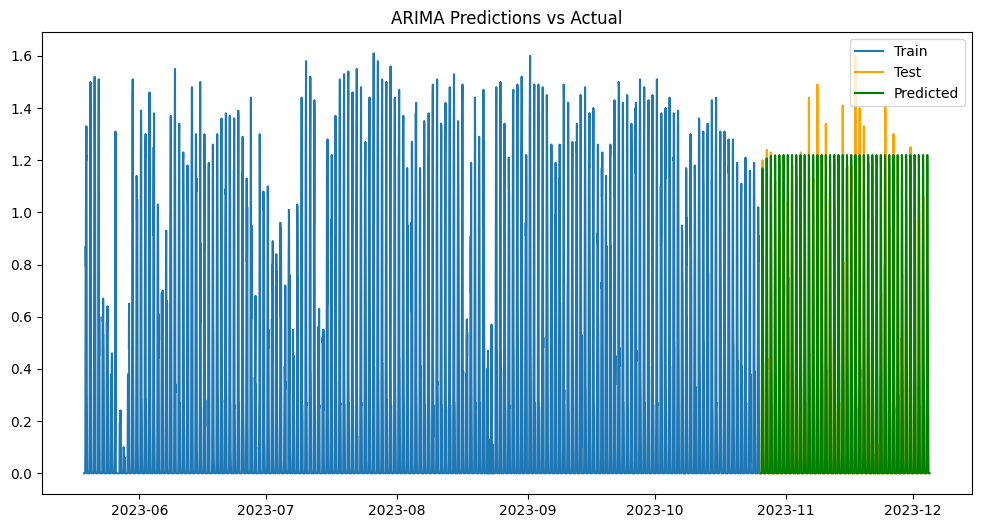

In [ ]:
# Train without exocgenous variables
def train_sarima_model():
    sarimax_model = SARIMAX(
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        order=order_params,
        seasonal_order=seasonal_params + (seasonal_period,),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    sarimax_result = sarimax_model.fit()
    preds = sarimax_result.predict(
        start=pre_gap_test.index[0], end=pre_gap_test.index[-1]
    )

    # Evaluate Predictions
    evaluate_predictions(pre_gap_test[DatasetColumns.PV_YIELD.value], preds)

    # Compare Actual vs Predicted
    compare_prediction(
        "SARIMA without Exogenous Predictions vs Actual",
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        pre_gap_test[DatasetColumns.PV_YIELD.value],
        preds,
    )


train_sarima_model()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.42170D-01    |proj g|=  1.38545D+00


 This problem is unconstrained.



At iterate    5    f= -5.69837D-01    |proj g|=  1.49352D-01

At iterate   10    f= -6.06302D-01    |proj g|=  1.55448D-01

At iterate   15    f= -6.32518D-01    |proj g|=  5.13871D-01

At iterate   20    f= -6.34052D-01    |proj g|=  5.30546D-03

At iterate   25    f= -6.34073D-01    |proj g|=  7.16502D-03

At iterate   30    f= -6.34074D-01    |proj g|=  5.20890D-04

At iterate   35    f= -6.34077D-01    |proj g|=  2.04231D-03

At iterate   40    f= -6.34146D-01    |proj g|=  3.18141D-02

At iterate   45    f= -6.34151D-01    |proj g|=  9.14017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     59   

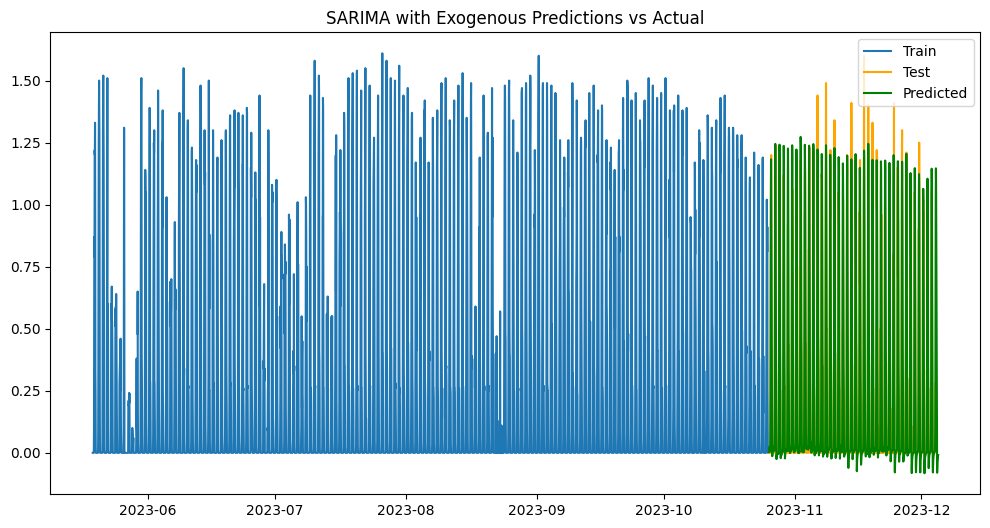

In [17]:
# Train with Exogenous Variables
def train_sarima_with_exogenous():
    # Merge weather data with primary dataset
    merged_train = pre_gap_train.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )
    merged_test = pre_gap_test.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )

    # Ensure exogenous variables are aligned and clean
    exog_train = merged_train[weather_features]
    exog_test = merged_test[weather_features]

    # Train SARIMA model with exogenous variables
    sarimax_model_exog = SARIMAX(
        merged_train[DatasetColumns.PV_YIELD.value],
        exog=exog_train,
        order=order_params,
        seasonal_order=seasonal_params + (seasonal_period,),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    sarimax_result_exog = sarimax_model_exog.fit()

    # Make predictions with exogenous variables
    preds_exog = sarimax_result_exog.predict(
        start=merged_test.index[0],
        end=merged_test.index[-1],
        exog=exog_test,
    )

    # Evaluate Predictions
    evaluate_predictions(merged_test[DatasetColumns.PV_YIELD.value], preds_exog)

    # Compare Actual vs Predicted
    compare_prediction(
        "SARIMA with Exogenous Predictions vs Actual",
        merged_train[DatasetColumns.PV_YIELD.value],
        merged_test[DatasetColumns.PV_YIELD.value],
        preds_exog,
    )


train_sarima_with_exogenous()